In [1]:
import alchemlyb
import glob, os
import numpy as np
import pandas as pd
from alchemlyb.estimators import TI,MBAR,BAR
from alchemlyb.parsing.gmx import extract_u_nk,extract_dHdl
import matplotlib.pyplot as plt
from alchemlyb.visualisation import plot_mbar_overlap_matrix,plot_ti_dhdl

from mult_fidelity_free_energy.MFTI import MFTI

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.

********* JAX NOT FOUND *********
 PyMBAR can run faster with JAX  
 But will work fine without it   
Either install with pip or conda:
      pip install pybar[jax]     
               OR                
      conda install pymbar       
*********************************


In [2]:
def read_dHdl_xvg(path,T):
    paths = glob.glob(path)
    p = np.argsort( [ int(pp.split(".")[-2] ) for pp in paths] )
    xvgs = np.array(paths)[p]

    return alchemlyb.concat([ extract_dHdl(xvg, T=T) for xvg in xvgs ])

def read_u_nk_xvg(path,T):
    paths = glob.glob(path)
    p = np.argsort( [ int(pp.split(".")[-2] ) for pp in paths] )
    xvgs = np.array(paths)[p]

    return alchemlyb.concat([ extract_u_nk(xvg, T=T) for xvg in xvgs ])


def reverse_plot(revs, time, labels, ref=None, savepath="",
                colors=["orange","green","magenta"]):
    msize=12
    fsize=15
    ffsize=20
    alpha=0.3
    lsize = 4      
    fig, ax = plt.subplots()
    for i,rev in enumerate(revs):
        ax.errorbar( time, rev[0], xerr=rev[1],
                 marker=".",markersize=msize,linewidth=lsize,
                 label=labels[i], color=colors[i])
        ax.errorbar( time, rev[2], xerr=rev[3],
                 marker=".",markersize=msize,linewidth=lsize,
                color=colors[i])
    if ref:
        plt.plot( time, np.ones(time.shape)*ref ,"-",color="grey",
                 label="ref",linewidth=lsize, zorder=100) 
    plt.xlim([np.min(time),np.max(time)])
    plt.ylabel(r"$\Delta$G", fontsize=ffsize)
    plt.xlabel( "time / ns", fontsize=ffsize-4)
    plt.legend(frameon=False, fontsize=fsize)
    plt.xticks(fontsize=fsize)
    plt.yticks(fontsize=fsize)
    plt.legend(fontsize=fsize,frameon=False,loc='center left', bbox_to_anchor=(1, 0.5))
    if savepath:
        plt.savefig(savepath+".png", bbox_inches='tight')
        plt.savefig(savepath+".pdf", bbox_inches='tight')
    plt.show()
    plt.close()
    return

def drop_dHdl(dHdl,idx):
    drp = np.unique( dHdl.index.get_level_values('vdw-lambda') )[idx]
    xx = dHdl.drop( index=drp,level=3)   
    return xx

def drop_u_nk(u_nk,idx):
    drp = np.unique( u_nk.index.get_level_values('vdw-lambda') )[idx]
    xx = u_nk.drop( index=drp,level=3)   
    #for dd in drp:
    #    dummy = np.array([np.array( aa )[2] for aa in np.array( xx.columns ) ])
    #    p = np.where(dummy != dd)
    #    xx = xx[ xx.columns[p] ] 
    return xx

In [3]:
T=313.15

path_pep = "example/peptide/pep.dhdl.*.xvg"
path_pro = "example/protein/dhdl.*.xvg"
drps = [None,
        ]

path_peps = [path_pep]
path_pros = [path_pro]

folder = ""


#os.makedirs(folder, exist_ok=True)


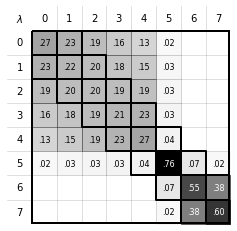

new time
t0 7500.0
mass-lambda


 /home/derwer/.local/lib/python3.10/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


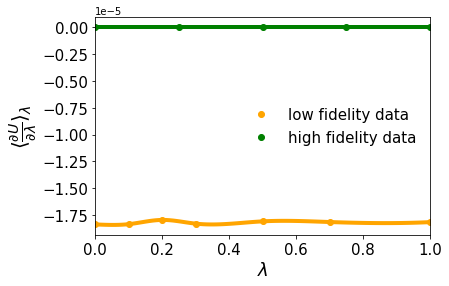

coul-lambda


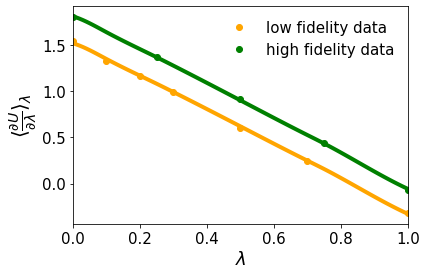

vdw-lambda


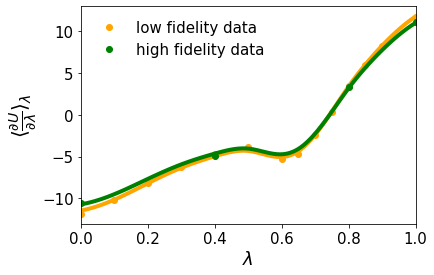

bonded-lambda
passed cause empty bonded-lambda
restraint-lambda
passed cause empty restraint-lambda
mass-lambda


 /home/derwer/.local/lib/python3.10/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


In [ ]:
for path_pep,path_pro in zip(path_peps,path_pros):
    
    path = folder + path_pro.split("/")[0]+ "/"
    os.makedirs(path, exist_ok=True)
    
    dHdl_pep_full = read_dHdl_xvg(path_pep,T)
    dHdl_pro_full = read_dHdl_xvg(path_pro,T)
    u_nk_pro_full = read_u_nk_xvg(path_pro,T)    

    dHdl_pep  = dHdl_pep_full
    dHdl_pro0 = dHdl_pro_full    
    u_nk_pro0 = u_nk_pro_full
    
    time = np.unique( dHdl_pro0.index.get_level_values(0) )
    tt = np.linspace(0,np.max(time),5)    
    
    mbar_ref = MBAR().fit(u_nk_pro0)
    dG_mbar_ref = round(np.array(alchemlyb.postprocessors.units.to_kJmol( mbar_ref.delta_f_ ) )[0][-1],4)
    ax = plot_mbar_overlap_matrix(mbar_ref.overlap_matrix)
    ax.figure.savefig(path+'overlap_ref.pdf')
    ax.figure.savefig(path+'overlap_ref.png')
    plt.show()
    plt.close()

    for i,idrp in enumerate(drps):
        if i>0:
            lambda_len = len( idrp )
            dHdl_pro = drop_dHdl(dHdl_pro0,idrp)
            u_nk_pro = drop_u_nk(u_nk_pro0,idrp)
        else:
            lambda_len = "full"
            dHdl_pro = dHdl_pro0
            u_nk_pro = u_nk_pro0           
    
        mfti_dGs     = []
        mfti_dGs_rev = []
        dmfti_dGs     = []
        dmfti_dGs_rev = []
        ti_dGs     = []
        ti_dGs_rev = []
        dti_dGs     = []
        dti_dGs_rev = []
        mbar_dGs     = []
        mbar_dGs_rev = []
        dmbar_dGs     = []
        dmbar_dGs_rev = []    
        for t0,t1 in zip( tt[1:],tt[:-1][::-1] ):
            print("new time")
            print("t0", t0)
            
            savepath0 = path + "_".join([str(int(t0)),str(lambda_len),str(i) ])
            os.makedirs(savepath0, exist_ok=True)
            savepath = savepath0+"/xxx"
            
            drp0 = time[ time > t0 ]
            dHdl_pro_dummy0 = dHdl_pro.drop( index=drp0,level=0)
            drp1 = time[ time <= t1 ]
            dHdl_pro_dummy1 = dHdl_pro.drop( index=drp1,level=0)

            u_nk_pro_dummy0 = u_nk_pro.drop( index=drp0,level=0)
            u_nk_pro_dummy1 = u_nk_pro.drop( index=drp1,level=0)        

            dHdl_pep['fidelity'] = 0
            dHdl_pro_f0 = dHdl_pro_dummy0.copy()
            dHdl_pro_f0['fidelity'] = 1
            dHdl_pro_f1 = dHdl_pro_dummy1.copy()
            dHdl_pro_f1['fidelity'] = 1    

            frames0 = [dHdl_pro_f0, dHdl_pep]
            frames1 = [dHdl_pro_f1, dHdl_pep]
            dHdl0 = pd.concat(frames0).set_index('fidelity', append=True)
            dHdl1 = pd.concat(frames1).set_index('fidelity', append=True)

            ti0 = TI().fit(dHdl_pro_dummy0) #.drop("fidelity", axis=1))
            ti1 = TI().fit(dHdl_pro_dummy1) #.drop("fidelity", axis=1))
            ti_dGs.append( round(np.array(alchemlyb.postprocessors.units.to_kJmol( ti0.delta_f_ ) )[0][-1],4) )
            ti_dGs_rev.append( round(np.array(alchemlyb.postprocessors.units.to_kJmol( ti1.delta_f_ ) )[0][-1],4) )
            dti_dGs.append( round(np.array(alchemlyb.postprocessors.units.to_kJmol( ti0.d_delta_f_ ) )[0][-1],4) )
            dti_dGs_rev.append( round(np.array(alchemlyb.postprocessors.units.to_kJmol( ti1.d_delta_f_ ) )[0][-1],4) )

            mfti0 = MFTI(savepath=savepath0).fit(dHdl0)
            mfti1 = MFTI(savepath=savepath0).fit(dHdl1)
            mfti_dGs.append( round(np.array(alchemlyb.postprocessors.units.to_kJmol( mfti0.delta_f_ ) )[0][-1],4) )
            mfti_dGs_rev.append( round(np.array(alchemlyb.postprocessors.units.to_kJmol( mfti1.delta_f_ ) )[0][-1],4) )
            dmfti_dGs.append( round(np.array(alchemlyb.postprocessors.units.to_kJmol( mfti0.d_delta_f_ ) )[0][-1],4) )
            dmfti_dGs_rev.append( round(np.array(alchemlyb.postprocessors.units.to_kJmol( mfti1.d_delta_f_ ) )[0][-1],4) )

            mbar0 = MBAR().fit(u_nk_pro_dummy0)
            mbar1 = MBAR().fit(u_nk_pro_dummy1)
            ax = plot_mbar_overlap_matrix(mbar0.overlap_matrix)
            ax.figure.savefig(savepath.replace("xxx","overlap")+'.pdf')
            ax.figure.savefig(savepath.replace("xxx","overlap")+'.png')
            plt.show()
            plt.close()
            #ax = plot_mbar_overlap_matrix(mbar1.overlap_matrix)
            mbar_dGs.append( round(np.array(alchemlyb.postprocessors.units.to_kJmol( mbar0.delta_f_ ) )[0][-1],4) )
            mbar_dGs_rev.append( round(np.array(alchemlyb.postprocessors.units.to_kJmol( mbar1.delta_f_ ) )[0][-1],4) )
            dmbar_dGs.append( round(np.array(alchemlyb.postprocessors.units.to_kJmol( mbar0.d_delta_f_ ) )[0][-1],4) )
            dmbar_dGs_rev.append( round(np.array(alchemlyb.postprocessors.units.to_kJmol( mbar1.d_delta_f_ ) )[0][-1],4) )

            #break

        revs = [ (ti_dGs, dti_dGs, ti_dGs_rev, dti_dGs_rev), 
                 (mbar_dGs, dmbar_dGs, mbar_dGs_rev, dmbar_dGs_rev),
                 (mfti_dGs, dmfti_dGs, mfti_dGs_rev, dmfti_dGs_rev),
               ]
        labels = ["TI","MBAR","MFTI"]
        reverse_plot( revs, tt[1:]/1000, labels, ref=-4.2, savepath=savepath.replace("xxx","dG_t") )        
        
        
        

In [ ]:
reverse_plot( revs, tt[1:]/1000, labels, ref=-4.2, savepath=savepath.replace("xxx","dG_t") )  